In [1]:
import os
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "4,5"
torch.cuda.device_count()

2

In [2]:
import transformers    

model = transformers.AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-hf",
    use_auth_token=True,
    device_map="auto",
    offload_folder="./offload"
)

tokenizer = transformers.AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
if tokenizer.pad_token is None:
    if tokenizer.eos_token is not None:
        tokenizer.pad_token = tokenizer.eos_token
    else:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})

from models.llama_7b import Llama

hooked_model = Llama(model, tokenizer)


/proj/inductive-bias.shadow/abakalov.anaconda/envs/sae/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/proj/inductive-bias.shadow/abakalov.anaconda/envs/sae/lib/python3.11/site-packages/transformers/models/auto/auto_factory.py:469: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 2/2 [00:08<00:00,  4.15s/it]


In [ ]:
from importlib import reload
import tasks.truthfulqa
reload(tasks.truthfulqa)

<module 'tasks.truthfulqa' from '/project/inductive-bias/llama/sae/tasks/truthfulqa.py'>

In [ ]:
import tasks.truthfulqa
task = tasks.truthfulqa.TruthfulQA("testing")
tokenized_dataset = task.get_tokenized_dataset(tokenizer=tokenizer, batch_size=2, num_select_items=100, max_length=1000)

In [ ]:
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
import torch
dataloader = DataLoader(tokenized_dataset, batch_size=2, shuffle=False)
correct = 0
sum_logit_diff = 0
with torch.no_grad():
    for iter, batch in tqdm(enumerate(dataloader)):
        batch_tokens = batch["tokens"].cuda()
        
        logits = hooked_model.model(batch_tokens).logits.cpu()
        correct_logits = [tokenizer.convert_tokens_to_ids(chr(ord("A") + label)) for label in batch["correct_label"]]
        incorrect_logits = [
                [
                    tokenizer.convert_tokens_to_ids(chr(ord("A") + label)) for label in range(num_labels) if label != correct_label
                ]
                for correct_label, num_labels in zip(batch["correct_label"], batch["num_labels"])
            ]
        incorrect_logits_probs = [np.array([logits[batch_i, -1, incorrect_id] for incorrect_id in incorrect_logits[batch_i]]) for batch_i in range(len(incorrect_logits))]
        max_incorrect_logit = [incorrect_logits[batch_i][np.argmax(incorrect_logits_probs[batch_i])] for batch_i in range(len(incorrect_logits))]
        logit_diff = [logits[batch_i, -1, correct_logits[batch_i]] - logits[batch_i, -1, max_incorrect_logit[batch_i]] for batch_i in range(len(incorrect_logits))]
        
        correct += (np.array(logit_diff) > 0).sum()
        sum_logit_diff += (np.array(logit_diff)).sum()
correct / len(tokenized_dataset), sum_logit_diff / len(tokenized_dataset)

409it [09:58,  1.46s/it]


(0.26560587515299877, -0.43834837093365675)

In [ ]:
import tasks.truthfulqa
task = tasks.truthfulqa.TruthfulQA("probing")
tokenized_dataset = task.get_tokenized_dataset(tokenizer=tokenizer, batch_size=2, num_select_items=100, max_length=1000)

In [ ]:
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import torch

accuracies = []
correct_activations = {(layer, head) : []
                       for layer in range(len(hooked_model.model.model.layers))
                       for head in range(hooked_model.model.model.layers[0].self_attn.num_heads)}

dataloader = DataLoader(tokenized_dataset, batch_size=2, shuffle=False)

with torch.no_grad():
    for batch in tqdm(dataloader):
        batch_tokens = batch["tokens"]
        hooked_model.model(batch_tokens)

        for layer in range(len(hooked_model.model.model.layers)):
            for head in range(hooked_model.model.model.layers[0].self_attn.num_heads):
                correct_activations[(layer, head)].append(hooked_model.cache_activations[(layer, head)][
                    np.arange(batch_tokens.shape[0]), batch["len_of_input"] - 1, :
                    ].detach().cpu())

for layer in range(len(hooked_model.model.model.layers)):
    for head in range(hooked_model.model.model.layers[0].self_attn.num_heads):
        correct_activations_dataset = torch.vstack(correct_activations[(layer, head)])
        X = correct_activations_dataset.numpy()
        y = np.array([1 if item["label"] == "True" else -1 for item in tokenized_dataset])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
        lr = LogisticRegression(penalty="l1", solver="liblinear").fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))

100%|██████████| 50/50 [00:33<00:00,  1.51it/s]


In [ ]:
accuracies_sorted = []
i = 0
for layer in range(len(hooked_model.model.model.layers)):
    for head in range(hooked_model.model.model.layers[0].self_attn.num_heads):
        accuracies_sorted.append((-accuracies[i], layer, head))
        i += 1
accuracies_sorted = sorted(accuracies_sorted)

In [ ]:
import json
with open("cache/accuracies_sorted.json", "r") as file:
    accuracies_sorted = json.load(file)

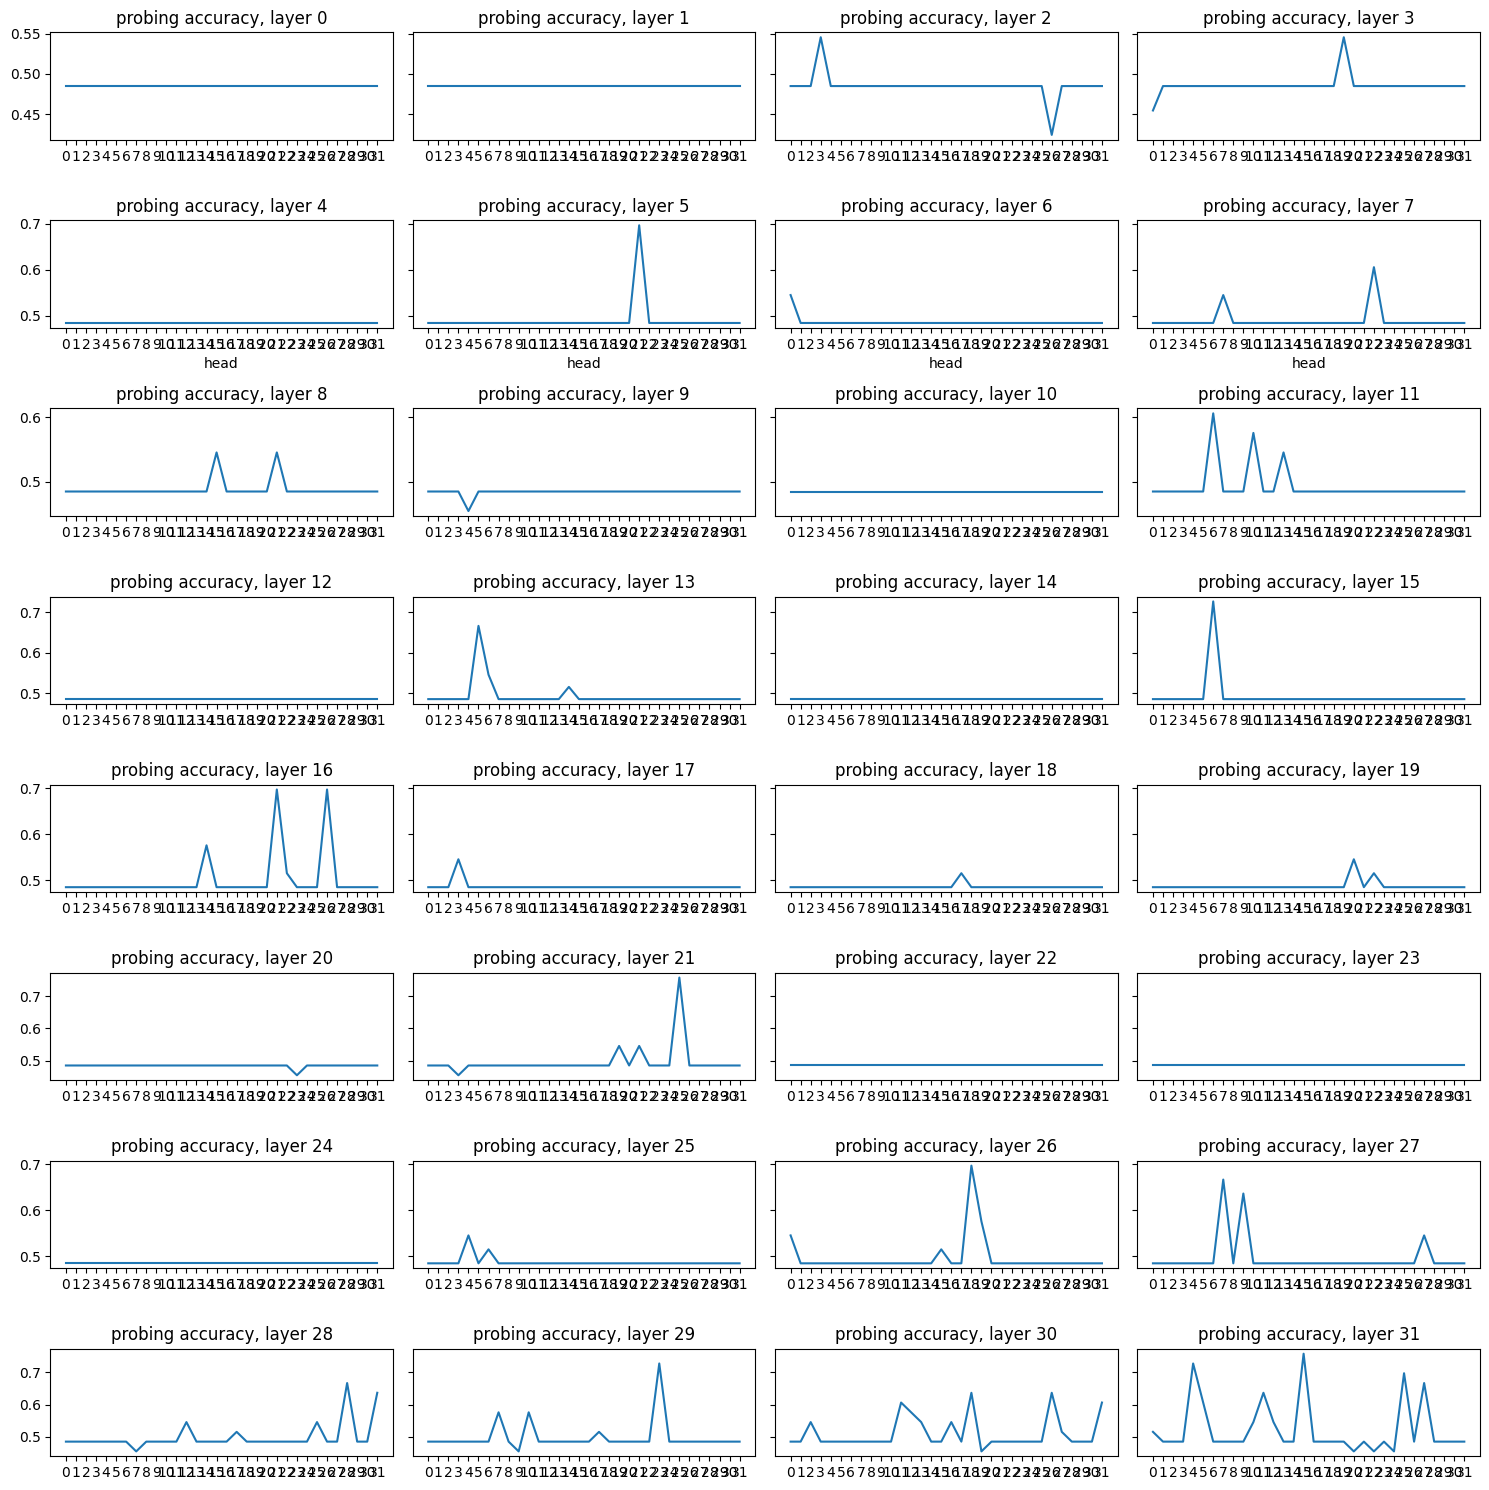

In [ ]:
import matplotlib.pyplot as plt
from collections import defaultdict
i = 0
accs_by_layer = defaultdict(list)
for layer in range(len(hooked_model.model.model.layers)):
    for head in range(hooked_model.model.model.layers[0].self_attn.num_heads):
        accs_by_layer[layer].append(accuracies[i])
        i += 1
        
fig, axs = plt.subplots(8, 4, sharey="row")
fig.set_size_inches((15, 15))
for i, layer in enumerate(accs_by_layer):
    y = i // 4
    x = i % 4
    axs[y][x].plot(accs_by_layer[layer])
    axs[y][x].set_title(f"probing accuracy, layer {layer}")

for i in range(8):
    for j in range(4):
        axs[i][j].set_xticks(np.arange(len(accs_by_layer[0])), labels=np.arange(len(accs_by_layer[0])))
        if i == 1:
            axs[i][j].set_xlabel("head")
fig.tight_layout()
plt.show()

In [3]:
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
import torch
import tasks.truthfulqa
task = tasks.truthfulqa.TruthfulQA("probing")
tokenized_dataset = task.get_tokenized_dataset(tokenizer=tokenizer, batch_size=2, num_select_items=100, max_length=1000)


steering_directions = {(layer, head): None for layer in range(32) for head in range(32)}
stds = {(layer, head): None for layer in range(32) for head in range(32)}

all_activations = {pos : [] for pos in steering_directions.keys()}

dataloader = DataLoader(tokenized_dataset, batch_size=2, shuffle=False)

with torch.no_grad():
    for batch in tqdm(dataloader):
        batch_tokens = batch["tokens"]
        hooked_model.model(batch_tokens)

        for layer, head in steering_directions.keys():
            all_activations[(layer, head)].append(hooked_model.cache_activations[(layer, head)][
                np.arange(batch_tokens.shape[0]), batch["len_of_input"] - 1, :
                ].detach().cpu())

for layer, head in steering_directions.keys():
    all_activations_dataset = torch.vstack(all_activations[(layer, head)])
    X = all_activations_dataset.numpy()
    y = np.array([1 if item["label"] == "True" else -1 for item in tokenized_dataset])
    pos_activations = X[y == 1]
    neg_activations = X[y == -1]
    steering_directions[(layer, head)] = np.mean(pos_activations, axis=0) - np.mean(neg_activations, axis=0)
    print(steering_directions[(layer, head)].shape)
    direction_norm = np.linalg.norm(steering_directions[(layer, head)])
    stds[(layer, head)] = np.std(np.dot(X, steering_directions[(layer, head)]) * direction_norm)

100%|██████████| 50/50 [00:10<00:00,  4.57it/s]


(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)

In [4]:
import json
with open("cache/steering_directions.json", "w") as file:
    json.dump({str(item): steering_directions[item].tolist() for item in steering_directions}, file)
with open("cache/stds.json", "w") as file:
    json.dump({str(item): stds[item].item() for item in stds}, file)
# import numpy as np
# import json
# with open("cache/steering_directions.json", "r") as file:
#     steering_directions_json = json.load(file)
# steering_directions = {}
# for item in steering_directions_json:
#     steering_directions[eval(item)] = np.array(steering_directions_json[item])
# with open("cache/stds.json", "r") as file:
#     stds_json = json.load(file)
# stds = {}
# for item in stds_json:
#     stds[eval(item)] = stds_json[item]

In [ ]:
import tasks.truthfulqa
task = tasks.truthfulqa.TruthfulQA("testing")
tokenized_dataset = task.get_tokenized_dataset(tokenizer=tokenizer, batch_size=2, max_length=1000)

In [ ]:
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
import torch
ks = [16, 32, 48, 64, 80, 96]
alphas = [5, 10, 15, 20, 25, 30]

accs = []
logit_diffs = []
for k in ks:
    for alpha in alphas:
        dataloader = DataLoader(tokenized_dataset, batch_size=2, shuffle=False)
        correct = 0
        sum_logit_diff = 0
        positions_to_steer = [(t[1], t[2], -1) for t in accuracies_sorted[:k]]
        vectors = [alpha * steering_directions[(pos[0], pos[1])] * stds[(pos[0], pos[1])] for pos in positions_to_steer]
        hooked_model.set_steering_vectors(vectors, positions_to_steer)
        with torch.no_grad():
            for iter, batch in tqdm(enumerate(dataloader)):
                batch_tokens = batch["tokens"].cuda()
                
                logits = hooked_model.model(batch_tokens).logits.cpu()
                correct_logits = [tokenizer.convert_tokens_to_ids(chr(ord("A") + label)) for label in batch["correct_label"]]
                incorrect_logits = [
                        [
                            tokenizer.convert_tokens_to_ids(chr(ord("A") + label)) for label in range(num_labels) if label != correct_label
                        ]
                        for correct_label, num_labels in zip(batch["correct_label"], batch["num_labels"])
                    ]
                incorrect_logits_probs = [np.array([logits[batch_i, -1, incorrect_id] for incorrect_id in incorrect_logits[batch_i]]) for batch_i in range(len(incorrect_logits))]
                max_incorrect_logit = [incorrect_logits[batch_i][np.argmax(incorrect_logits_probs[batch_i])] for batch_i in range(len(incorrect_logits))]
                logit_diff = [logits[batch_i, -1, correct_logits[batch_i]] - logits[batch_i, -1, max_incorrect_logit[batch_i]] for batch_i in range(len(incorrect_logits))]
                
                correct += (np.array(logit_diff) > 0).sum()
                sum_logit_diff += (np.array(logit_diff)).sum()
        accs.append(correct / len(tokenized_dataset))
        logit_diffs.append(sum_logit_diff / len(tokenized_dataset))
        print(k, alpha, accs[-1])

409it [10:24,  1.53s/it]


16 5 0.22031823745410037


208it [05:05,  1.47s/it]


KeyboardInterrupt: 

In [ ]:
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
import torch
ks = [48, 64, 80, 96]
alphas = [20, 25, 30]

accs = []
logit_diffs = []
for k in ks:
    for alpha in alphas:
        dataloader = DataLoader(tokenized_dataset, batch_size=2, shuffle=False)
        correct = 0
        sum_logit_diff = 0
        positions_to_steer = [(t[1], t[2], -1) for t in accuracies_sorted[:k]]
        vectors = [alpha * steering_directions[(pos[0], pos[1])] * stds[(pos[0], pos[1])] for pos in positions_to_steer]
        hooked_model.set_steering_vectors(vectors, positions_to_steer)
        with torch.no_grad():
            for iter, batch in tqdm(enumerate(dataloader)):
                batch_tokens = batch["tokens"].cuda()
                
                logits = hooked_model.model(batch_tokens).logits.cpu()
                correct_logits = [tokenizer.convert_tokens_to_ids(chr(ord("A") + label)) for label in batch["correct_label"]]
                incorrect_logits = [
                        [
                            tokenizer.convert_tokens_to_ids(chr(ord("A") + label)) for label in range(num_labels) if label != correct_label
                        ]
                        for correct_label, num_labels in zip(batch["correct_label"], batch["num_labels"])
                    ]
                incorrect_logits_probs = [np.array([logits[batch_i, -1, incorrect_id] for incorrect_id in incorrect_logits[batch_i]]) for batch_i in range(len(incorrect_logits))]
                max_incorrect_logit = [incorrect_logits[batch_i][np.argmax(incorrect_logits_probs[batch_i])] for batch_i in range(len(incorrect_logits))]
                logit_diff = [logits[batch_i, -1, correct_logits[batch_i]] - logits[batch_i, -1, max_incorrect_logit[batch_i]] for batch_i in range(len(incorrect_logits))]
                
                correct += (np.array(logit_diff) > 0).sum()
                sum_logit_diff += (np.array(logit_diff)).sum()
        accs.append(correct / len(tokenized_dataset))
        logit_diffs.append(sum_logit_diff / len(tokenized_dataset))
        print(k, alpha, accs[-1])

409it [10:15,  1.51s/it]


48 20 0.22031823745410037


409it [10:23,  1.52s/it]


48 25 0.22031823745410037


409it [10:15,  1.50s/it]


48 30 0.22031823745410037


409it [10:05,  1.48s/it]


64 20 0.204406364749082


325it [07:34,  1.40s/it]


KeyboardInterrupt: 

In [ ]:
with open("cache/accs.json", "w") as file:
    json.dump(accs, file)